In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
sys.path.insert(1, '../')
from ml_functions import *

#### PREPARATION OF DATASETS ####

train_df_raw = pd.read_csv('../../steps/train_df_sex.csv')
train_df_raw.drop(list(train_df_raw)[0], axis = 1, inplace = True)
train_labels = train_df_raw.Sex
train_df_raw.head()

test_df_raw = pd.read_csv('../../steps/test_df_sex.csv')
test_labels = test_df_raw.Sex
test_df_raw.drop(list(test_df_raw)[:2], axis = 1, inplace = True)

################### SCALING #######################
from sklearn.preprocessing import MinMaxScaler, StandardScaler
train_df_raw.drop('Sex', axis = 1, inplace = True)

minmaxscaler = MinMaxScaler()
minmaxscaler.fit(train_df_raw)
train_df_minmax = minmaxscaler.transform(train_df_raw)
test_df_minmax = minmaxscaler.transform(test_df_raw)

standscaler = StandardScaler()
standscaler.fit(train_df_raw)
train_df_stand = standscaler.transform(train_df_raw)
test_df_stand = standscaler.transform(test_df_raw)

#### IMPORTING FUNCTIONS USED FOR MODELLING ####

from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, matthews_corrcoef
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
rs = 26
# SVM -DONE
svc_mod = SVC(C = 1, gamma = 'auto', kernel = 'linear', probability = True, random_state=rs)

# Logistic regression - DONE
log_mod = LogisticRegression(penalty = 'l2', solver = 'liblinear', C = 2, random_state=rs)

# LDA - DONE
lda_mod = LinearDiscriminantAnalysis(shrinkage = 0.5, solver = 'lsqr')

# QDA - DONE
qda_mod = QuadraticDiscriminantAnalysis(reg_param = 0.75)

# Gradient Boosting DONE
gr_mod = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2, max_features = 0.1, 
                                    min_samples_leaf = 20, min_samples_split = 15, n_estimators = 1000, subsample = 1, random_state = rs)

# Adaptive Boosting - DONE
ada_mod = AdaBoostClassifier(n_estimators = 500, learning_rate = 1, random_state = rs)

# XGBoost # DONE
xgb_mod = XGBClassifier(colsample_bynode = 0.775, colsample_bytree = 1, learning_rate = 1, 
                        max_depth = 2, n_estimators = 1000, reg_lambda = 1000, subsample = 0.325, random_state = rs)

# RandomForest # DONE
#rf_mod = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = None, 
#                                min_samples_leaf = 5, min_samples_split = 20, n_estimators = 1000, random_state = rs)
rf_mod = RandomForestClassifier(bootstrap = True, max_depth = 6, max_features = 'sqrt', 
                                min_samples_leaf = 5, min_samples_split = 10, n_estimators = 1000, random_state = rs)


### PCA ### - DONE
pca = PCA(svd_solver = 'full')
pca.fit(train_df_stand)
train_pcs = pca.transform(train_df_stand)
test_pcs = pca.transform(test_df_stand)

# pca-lda - DONE
pca_lda = LinearDiscriminantAnalysis(shrinkage = 0.1, solver = 'lsqr')
pca_lda.fit(train_pcs[:, :112], train_labels) # 38 is the max we can use because of the size of the test data set. Otherwise best is ~112

# pca_qda - DONE
pca_qda = QuadraticDiscriminantAnalysis(reg_param = 0.75)
pca_qda.fit(train_pcs[:, :30], train_labels)

# KNN #DONE
knn_mod = KNeighborsClassifier(n_neighbors = 6, algorithm = 'auto', weights = 'uniform')

In [3]:
models = [svc_mod, log_mod, lda_mod, qda_mod, gr_mod, ada_mod, xgb_mod, rf_mod, knn_mod]
model_names = ['SVM', 'LogReg', 'LDA', 'QDA', 'GrBoost', 'AdaBoost', 'XGBoost', 'RF', 'KNN']

In [4]:
# Fitting all the non-pca models
for model in models:
    model.fit(train_df_minmax, train_labels)

/home/tomas/anaconda3/envs/pyml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


# Best Features

For `SVC`, `LDA`, `LogReg` there is no problem, because they are not dependent on  the random state. However the ensemble methods change with every new modelling, thus I am going to try `10` (because its a nice number) different random states, compute the feature importance for each and output the mean feature importance

In [5]:
def ensemble_feature_importances(model, n = 10, rs = 26):
    """This is for `unstable` methods that generate different model each time they are called - ensemble tree methods"""
    importances = []
    for i in range(n):
        model.set_params(**{'random_state':i}) # change random state
        model.fit(train_df_minmax, train_labels) # train model
        importances.append(list(model.feature_importances_)) # append feature importances

    return np.mean(importances, axis = 0)

In [6]:
features_sex = pd.DataFrame({
    'SVC':svc_mod.coef_[0],
    'LoR':log_mod.coef_[0],
    'LDA':lda_mod.coef_[0],
    'GrB':ensemble_feature_importances(gr_mod),
    'Ada':ensemble_feature_importances(ada_mod),
    'XGB':ensemble_feature_importances(xgb_mod),
    'RnF':ensemble_feature_importances(rf_mod)
}, index = list(train_df_raw))

features_sex = features_sex.sort_index()
features_sex.head()

,SVC,LoR,LDA,GrB,Ada,XGB,RnF
"1,5-Anhydro-D-sorbitol TMS4",-0.156155,-0.358606,-3.333000,0.008354,0.016,0.004583,0.004970
2-Hydroxy-3-methyl-butyric acid TMS2,-0.199074,-0.558451,-4.485218,0.034330,0.014,0.007479,0.016551
2-Hydroxy-pyridine TMS,-0.065410,-0.095193,-1.388863,0.000018,0.000,0.002292,0.000453
2-Keto-4-methyl-valeric acid MEOX-TMS,-0.146925,-0.225001,-2.866883,0.000092,0.002,0.002860,0.003993
3-Hydroxy-3-methyl-butyric acid TMS2,-0.162246,-0.459334,-3.728630,0.000394,0.000,0.003879,0.003919


For each predictor I rank the features based on their coefficients, so that the most important predictors have very low ranks. Then I sum all the ranks to find out which predictors are best (very likely)

In [7]:
def rank_features(df, i):
    tempdf = pd.DataFrame(np.abs(df.iloc[:,i]).sort_values(ascending = False)) # sort coefficients
    tempdf['Ranking'] = np.arange(len(tempdf)) # rank them
    return np.array(tempdf.sort_index()['Ranking']) # return just the rank - and making sure that row indices in input and output match

In [8]:
rankings = []
for i in range(features_sex.shape[1]):
    rankings.append(rank_features(features_sex, i))
    
ranking_df = pd.DataFrame(np.array(rankings).T, columns = np.array(features_sex.columns), index = np.array(features_sex.index))

In [9]:
ranking_df.head()

,SVC,LoR,LDA,GrB,Ada,XGB,RnF
"1,5-Anhydro-D-sorbitol TMS4",84,75,51,25,12,44,38
2-Hydroxy-3-methyl-butyric acid TMS2,46,20,16,9,16,16,15
2-Hydroxy-pyridine TMS,241,305,203,241,217,149,324
2-Keto-4-methyl-valeric acid MEOX-TMS,97,162,71,184,136,103,46
3-Hydroxy-3-methyl-butyric acid TMS2,73,42,33,120,218,64,47


In [11]:
best_features_sex = pd.DataFrame({'Median_rank':np.median(ranking_df, axis=1)}, index = ranking_df.index).sort_values('Median_rank',ascending = True)[:15]
best_features_sex

,Median_rank
Creatinine calculated using MDRD formula,1.0
Phosphate,2.0
unknown 3.94,2.0
Isoleucine,4.0
Uric acid,5.0
...,...
unknown 3.60,386.0
Similar to N-Formyl-glycine TMS2,397.0
Unknown 0075,399.0
myristic acid,402.0


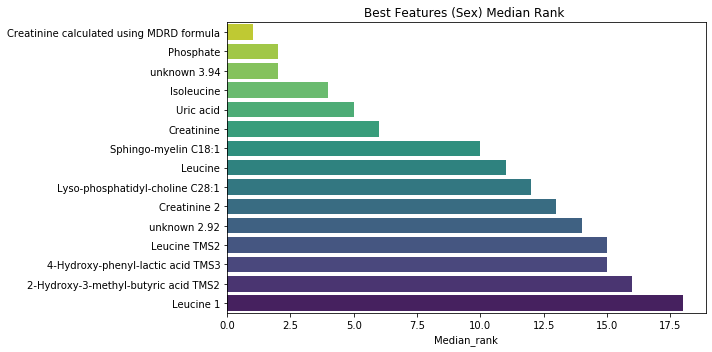

In [54]:
plt.figure(figsize=(10, 5))
sns.barplot(y = best_features_sex.index, x = best_features_sex.Median_rank, palette='viridis_r')
plt.title('Best Features (Sex) Median Rank ')
plt.tight_layout()
plt.savefig('../../plots/Sex_prediction/best_features_sex.png', dpi = 150)

In [66]:
features_sex.loc[:, ['SVC', 'LoR', 'LDA']].shape

(441, 3)

In [121]:
cordirr = np.empty((441, 3))

for i in range(441):
    for j in range(3):
        if features_sex.loc[:, ['SVC', 'LoR', 'LDA']].iloc[i, j] > 0:
            cordirr[i, j] = -1 # this seems like its wrong but the reason for this is to have weights that are positive to be associated with males
            # and opposite is for females
        else:
            cordirr[i, j] = 1

In [122]:
correlation_dirrection = np.median(cordirr, axis = 1)
correlation_dirrection = ['Positive' if i == 1 else 'Negative' for i in correlation_dirrection]

In [123]:
best_features_sex = pd.DataFrame({'Median_rank':np.median(ranking_df, axis=1), 
             'Correlation':correlation_dirrection}, index = ranking_df.index).sort_values('Median_rank',ascending = True)[:15]

In [124]:
best_features_sex

,Median_rank,Correlation
Creatinine calculated using MDRD formula,1.0,Positive
Phosphate,2.0,Negative
unknown 3.94,2.0,Negative
Isoleucine,4.0,Positive
Uric acid,5.0,Positive
Creatinine,6.0,Positive
Sphingo-myelin C18:1,10.0,Negative
Leucine,11.0,Positive
Lyso-phosphatidyl-choline C28:1,12.0,Negative
Creatinine 2,13.0,Positive


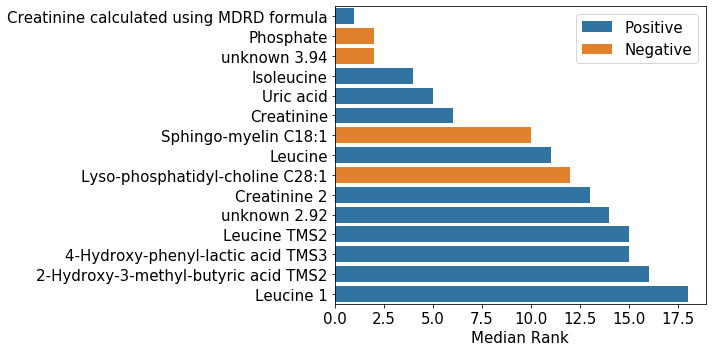

In [126]:
plt.figure(figsize=(10, 5))
sns.barplot(y = best_features_sex.index, x = best_features_sex.Median_rank, hue = best_features_sex.Correlation,
           dodge = False, hue_order = ['Positive', 'Negative'],
                 palette = {'Positive':'C0', 'Negative':'C1'})
#plt.title('Best Features (Sex) Median Rank ')

plt.legend(fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xlabel('Median Rank', size = 15)

plt.tight_layout()
plt.savefig('../../plots/Sex_prediction/best_features_sex.png', dpi = 150)

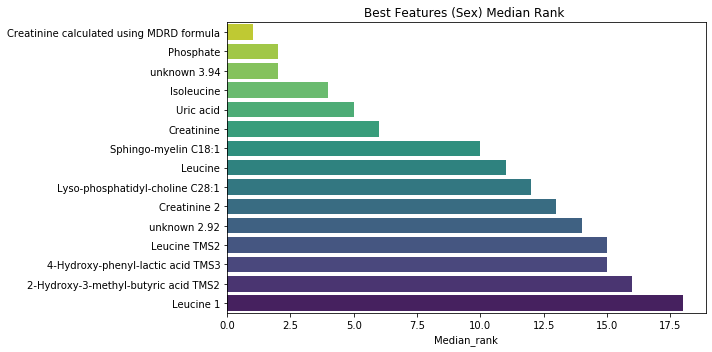

In [52]:
plt.figure(figsize=(10, 5))
sns.barplot(y = best_features_sex.index, x = best_features_sex.Median_rank, palette='viridis_r')
plt.title('Best Features (Sex) Median Rank ')
plt.tight_layout()
#plt.savefig('../../plots/Sex_prediction/best_features_sex.png', dpi = 150)

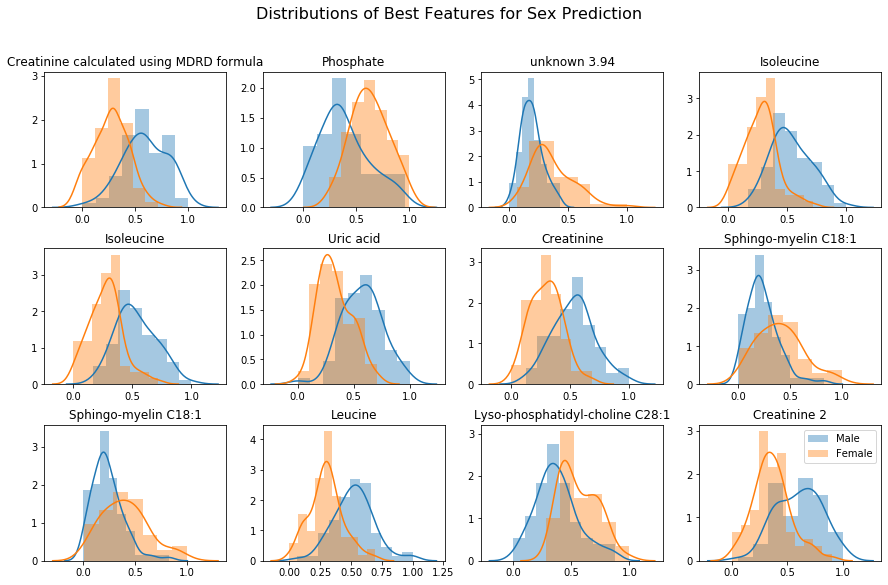

In [57]:
fig, ax = plt.subplots(3, 4, figsize = (15, 9))

for i in range(3):
    for j in range(4):
        ind = list(train_df_raw).index(best_features_sex.index[3*i+j])
        sns.distplot(train_df_minmax[:, ind][train_labels == 1], label = 'Male', ax = ax[i, j])
        sns.distplot(train_df_minmax[:, ind][train_labels == 2], label = 'Female', ax = ax[i, j])
        #ax[i, j].legend()
        ax[i, j].set_title(best_features_sex.index[3*i+j])
ax[2, 3].legend()
plt.subplots_adjust(hspace = 0.3)
fig.suptitle('Distributions of Best Features for Sex Prediction', size = 16)
plt.savefig('../../plots/Sex_prediction/best_features_distributions.png', dpi = 200);

## How certain are the models about the predictions?

(array([29., 38.,  0.,  4.,  6.,  1.,  5., 11., 14., 44.]),
 array([0.96806553, 0.97125898, 0.97445242, 0.97764586, 0.98083931,
        0.98403275, 0.9872262 , 0.99041964, 0.99361308, 0.99680653,
        0.99999997]),
 <a list of 10 Patch objects>)

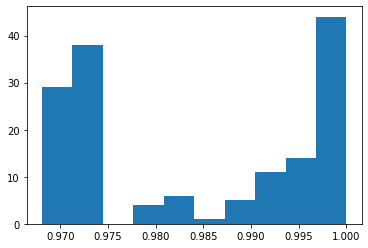

In [21]:
plt.hist(np.max(svc_mod.predict_proba(train_df_minmax), axis = 1))

(array([ 3.,  4.,  5., 10.,  7.,  7.,  9., 30., 34., 43.]),
 array([0.51717331, 0.56391571, 0.61065812, 0.65740052, 0.70414293,
        0.75088533, 0.79762774, 0.84437014, 0.89111255, 0.93785495,
        0.98459736]),
 <a list of 10 Patch objects>)

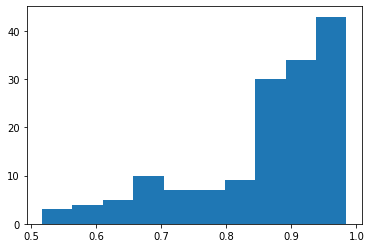

In [40]:
plt.hist(np.max(rf_mod.predict_proba(train_df_minmax), axis = 1))

In [94]:
from sklearn.model_selection import cross_val_predict

In [115]:
def model_confidence(model, df, labels, title = None, axi = None, ylab = None, fs = 15, cv = 10, train = True, colors = ['C0', 'C1'], alpha = 0.4):
    if train:
        prob_predict = cross_val_predict(model, df, labels, method = 'predict_proba', cv = cv)
    else:
        prob_predict = model.predict_proba(df)
    prob_predict[:, 1] = -prob_predict[:, 1] + 1 
    
    probs = []
    for i in range(len(prob_predict)):
        m = np.argmax([prob_predict[i, 0], np.abs(prob_predict[i, 1])])
        probs.append(prob_predict[i, m])
        
    yax = np.random.rand(len(probs))
    
    if axi is None:
        plt.axvspan(0.5, 1, alpha = 0.2)
        plt.axvspan(0, 0.5, alpha = 0.2, color = 'red')
        plt.plot(np.array(probs)[labels == 1], yax[labels == 1], '.', color = colors[0], markersize = 10)
        plt.plot(np.array(probs)[labels == 2], yax[labels == 2], '.', color = colors[1], markersize = 10)

        plt.yticks([])
    else:
        ax[axi[0], axi[1]].axvspan(0.5, 1, alpha = 0.1, color = colors[0])
        ax[axi[0], axi[1]].axvspan(0, 0.5, alpha = 0.1, color = colors[1])
        ax[axi[0], axi[1]].plot(np.array(probs)[labels == 1], yax[labels == 1], '.', color = colors[0],markersize = 10, alpha = alpha)
        ax[axi[0], axi[1]].plot(np.array(probs)[labels == 2], yax[labels == 2], '.', color = colors[1], markersize = 10, alpha = alpha)
        ax[axi[0], axi[1]].axes.yaxis.set_ticklabels([])
        ax[axi[0], axi[1]].set_title(title, size = fs)
        ax[axi[0], axi[1]].set_ylabel(ylab, size = fs)

/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

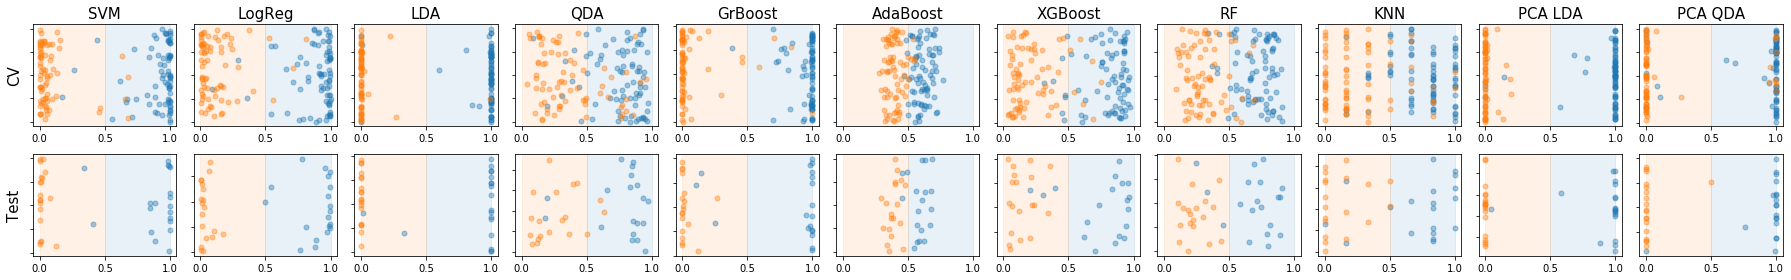

In [116]:
fig, ax = plt.subplots(2, 11, figsize = (25, 4))

for i, model in enumerate(models):
    model_confidence(model, train_df_minmax, train_labels, f'{model_names[i]}', axi = [0, i])

for i, model in enumerate(models):
    model_confidence(model, test_df_minmax, test_labels, '', axi = [1, i], train = False)

model_confidence(pca_lda, train_pcs[:, :112], train_labels, 'PCA LDA', axi = [0, 9])
model_confidence(pca_lda, test_pcs[:, :112], test_labels, '', axi = [1, 9], train = False)

model_confidence(pca_qda, train_pcs[:, :30], train_labels, 'PCA QDA', axi = [0, 10])
model_confidence(pca_qda, test_pcs[:, :30], test_labels, '', axi = [1, 10], train = False)

ax[0, 0].set_ylabel('CV')
ax[1, 0].set_ylabel('Test')

plt.tight_layout()
plt.savefig('../../plots/Sex_prediction/model_confidence.png', dpi = 200)

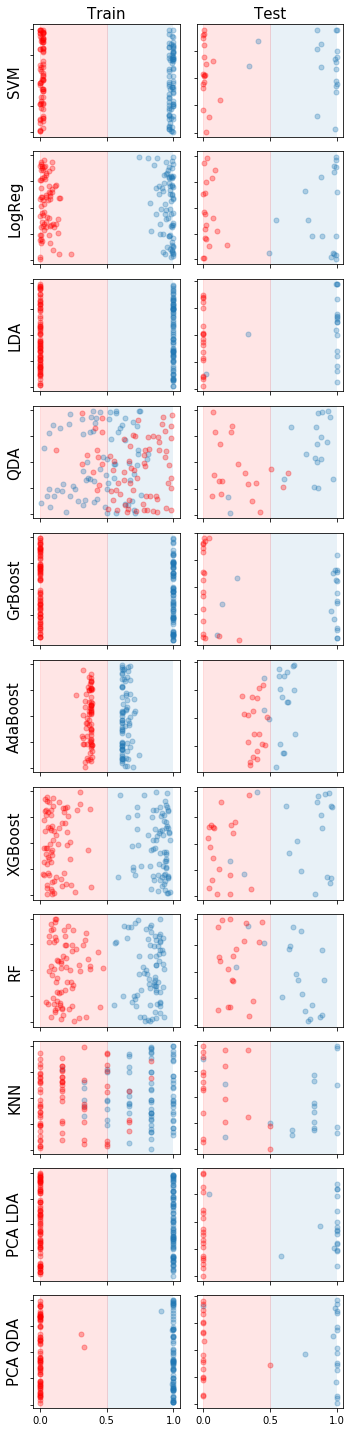

In [71]:
fig, ax = plt.subplots(11, 2, figsize = (5, 20), sharex = True)

for i, model in enumerate(models):
    model_confidence(model, train_df_minmax, train_labels, ylab = f'{model_names[i]}', axi = [i, 0])

for i, model in enumerate(models):
    model_confidence(model, test_df_minmax, test_labels, axi = [i, 1], train = False)

model_confidence(pca_lda, train_pcs[:, :112], train_labels, ylab = 'PCA LDA', axi = [9, 0])
model_confidence(pca_lda, test_pcs[:, :112], test_labels, axi = [9, 1], train = False)

model_confidence(pca_qda, train_pcs[:, :30], train_labels, ylab = 'PCA QDA', axi = [10, 0])
model_confidence(pca_qda, test_pcs[:, :30], test_labels, axi = [10, 1], train = False)

ax[0, 0].set_title('CV', size = 15)
ax[0, 1].set_title('Test', size = 15)

plt.tight_layout()
plt.savefig('../../plots/Sex_prediction/model_confidence_vertical.png', dpi = 200)

### only few models

In [108]:
picked_models = [svc_mod, log_mod, lda_mod, xgb_mod, knn_mod]
picked_model_names = ['SVM', 'LogReg', 'LDA', 'XGB', 'KNN']

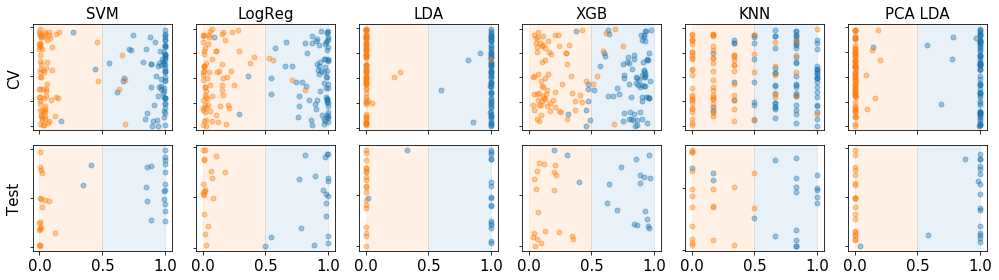

In [117]:
clrs = ['C0', 'C1']
al = 0.4

fig, ax = plt.subplots(2, 6, figsize = (14, 4), sharex = True)

for i, model in enumerate(picked_models):
    model_confidence(model, train_df_minmax, train_labels, f'{picked_model_names[i]}', axi = [0, i])

for i, model in enumerate(picked_models):
    model_confidence(model, test_df_minmax, test_labels, '', axi = [1, i], train = False)

model_confidence(pca_lda, train_pcs[:, :112], train_labels, 'PCA LDA', axi = [0, 5])
model_confidence(pca_lda, test_pcs[:, :112], test_labels, '', axi = [1, 5], train = False)

ax[0, 0].set_ylabel('CV')
ax[1, 0].set_ylabel('Test')

for i in range(6): 
    ax[1, i].axes.tick_params(labelsize = 15)

plt.tight_layout()
plt.savefig('../../plots/Sex_prediction/model_confidence_some.png', dpi = 200)

(array([20., 24., 16., 22., 16., 12., 11., 10.,  9., 12.]),
 array([0.50341849, 0.55258075, 0.60174301, 0.65090526, 0.70006752,
        0.74922978, 0.79839204, 0.8475543 , 0.89671656, 0.94587881,
        0.99504107]),
 <a list of 10 Patch objects>)

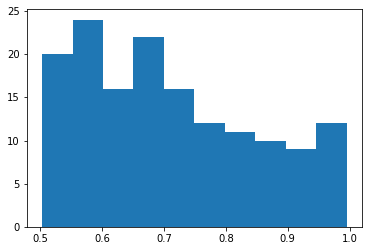

In [32]:
plt.hist(np.max(qda_mod.predict_proba(train_df_minmax), axis = 1))

In [31]:
qda_mod.predict_proba(train_df_minmax)

array([[0.73449593, 0.26550407],
       [0.98765814, 0.01234186],
       [0.87510594, 0.12489406],
       [0.89187147, 0.10812853],
       [0.44919997, 0.55080003],
       [0.44925052, 0.55074948],
       [0.07075256, 0.92924744],
       [0.65935889, 0.34064111],
       [0.66618934, 0.33381066],
       [0.493181  , 0.506819  ],
       [0.98462928, 0.01537072],
       [0.35334951, 0.64665049],
       [0.41427838, 0.58572162],
       [0.57128569, 0.42871431],
       [0.42640188, 0.57359812],
       [0.22400611, 0.77599389],
       [0.50429206, 0.49570794],
       [0.21650325, 0.78349675],
       [0.93421199, 0.06578801],
       [0.40445861, 0.59554139],
       [0.55434744, 0.44565256],
       [0.81011354, 0.18988646],
       [0.73513525, 0.26486475],
       [0.72386053, 0.27613947],
       [0.87275943, 0.12724057],
       [0.64010068, 0.35989932],
       [0.00495893, 0.99504107],
       [0.74889903, 0.25110097],
       [0.72388511, 0.27611489],
       [0.66814988, 0.33185012],
       [0.

# Which instances are misclassified?

Idea here is to look at each model and find out whether there are some instances that all models have problems with. To do that I use cross-validation to predict the training dataset several times, and each time I extract the IDs of misclassified observations. In every run I generate a vector that is consisted mostly of zeros, and with ones on misclassified positions. This allows me to easily sum multiple vectors for the several runs of cv. If some instances are going to be misclassified again and again, the number for an observation on the resulting vector (which is the sum of all vectors from previous iterations) will be high.

But if the classifier is very variable, it wont give much information, thus good clasifiers will be more priviliged.

In [42]:
from sklearn.model_selection import cross_val_predict

In [61]:
def misclassified(model, n, random_state = None):
    # generate vector with `1` on misclassified postions and `0` elsewhere
    misclassified_obs = np.zeros(train_df_minmax.shape[0])
    for i in range(n):
        if random_state != None:
            model = model.set_params(**{'random_state':random_state})
        # generate vector with `1` on misclassified postions and `0` elsewhere
        mo_temp = np.array(cross_val_predict(model, train_df_minmax, train_labels, cv = 10) != train_labels)*1
        # add this new vector to the already existing one
        misclassified_obs += mo_temp
    return misclassified_obs

In [62]:
for j in range(5):
    m = misclassified(xgb_mod, 1, random_state = j)
    print([i for i in range(train_df_minmax.shape[0]) if m[i] == 1])

[6, 10, 22, 31, 42, 48, 66, 78, 104, 130, 135, 140, 141, 144]
[6, 10, 22, 42, 48, 66, 78, 130, 140, 141, 144]
[6, 10, 22, 31, 42, 48, 66, 78, 104, 130, 135, 140, 141, 144]
[6, 10, 22, 31, 42, 48, 66, 78, 104, 130, 140, 141, 144]
[6, 10, 18, 22, 31, 32, 42, 48, 66, 78, 130, 135, 140, 141, 144]


In [66]:
stable_models = [svc_mod, log_mod, lda_mod, qda_mod, knn_mod, pca_lda, pca_qda]
unstable_models = [gr_mod, ada_mod, xgb_mod, rf_mod,]
model_names = ['SVM', 'LoR', 'LDA', 'QDA', 'KNN', 'PCALDA', 'PCAQDA', 'GrB', 'Ada', 'XGB', 'RnF']

all_misclassified = []

for model in stable_models:
    all_misclassified.append(misclassified(model, 5))

for model in unstable_models:
    temp_results = np.zeros(train_df_minmax.shape[0])
    for j in range(5):
        temp_results += misclassified(model, 1, random_state = j)
        
    all_misclassified.append(temp_results)

miscl_df = pd.DataFrame(np.array(all_misclassified).T, columns = model_names)

/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

In [67]:
msobs = np.sum(miscl_df, axis = 1).sort_values(ascending = False)
msobs[:10]

42     45.0
144    45.0
130    40.0
141    40.0
10     35.0
82     35.0
48     30.0
6      30.0
140    30.0
31     23.0
dtype: float64

In [58]:
msobs.index[0]

144

In [64]:
list(train_df_raw).index(best_features_sex.index[0])

264

In [67]:
train_df_raw.iloc[[144, 130, 42, 82, 141], list(train_df_raw).index(best_features_sex.index[0])]

144    0.8
130    0.7
42     0.7
82     0.9
141    0.7
Name: Creatinine calculated using MDRD formula, dtype: float64

In [66]:
train_df_minmax[144, list(train_df_raw).index(best_features_sex.index[0])]

0.4285714285714287

In [48]:
train_labels[141]

2

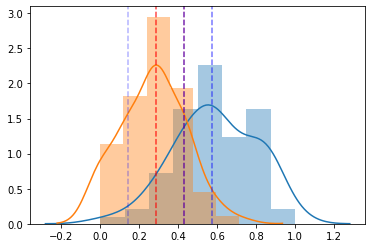

In [52]:
sns.distplot(train_df_minmax[:, list(train_df_raw).index(best_features_sex.index[0])][train_labels == 1], label = 'Male')
sns.distplot(train_df_minmax[:, list(train_df_raw).index(best_features_sex.index[0])][train_labels == 2], label = 'Female')
for i in range(10):
    val = train_df_minmax[msobs.index[i], list(train_df_raw).index(best_features_sex.index[0])]
    if train_labels[msobs.index[i]] == 2:
        cl = 'red'
    else:
        cl = 'blue'
    #plt.plot(msobs.index[i], msobs.values[i], color = cl)
    plt.axvline(val, color = cl, ls = '--', alpha = 0.3);

### Are the more misclassified men or women? (in the top 10 misclassified features)

In [83]:
np.mean(np.array([train_labels[msobs.index[i]] for i in range(10)]) == 2)

0.5

In [84]:
np.mean(np.array([train_labels[msobs.index[i]] for i in range(50)]) == 2)

0.48

Perfectly balanced

# Is the assumption of Normality really that important?

In [36]:
train_df_unskewed = np.array(fix_skew(pd.DataFrame(train_df_raw)))
train_df_unskewed_minmax = MinMaxScaler().fit_transform(train_df_unskewed)

In [37]:
train_df_unskewed.shape

(152, 441)

In [38]:
def before_after_skewfix(dfs, dfu, i):
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    ax[0].hist(dfs[:, i])
    ax[0].set_title('Before')
    ax[1].hist(dfu[:, i])
    ax[1].set_title('After')

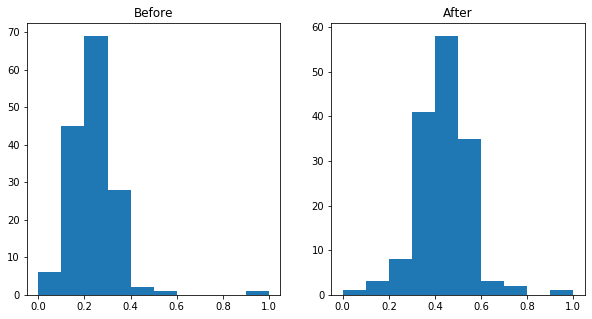

In [39]:
before_after_skewfix(train_df_minmax, train_df_unskewed_minmax, 12)

In [20]:
from classification_gridsearch import da

**LDA** should be sensitive to this 

In [22]:
da(train_df_minmax, train_labels)

([({'shrinkage': 0.5257894736842105, 'solver': 'eigen'}, 0.9736904761904762),
  ({'shrinkage': 0.5257894736842105, 'solver': 'lsqr'}, 0.9736904761904762),
  ({'shrinkage': 0.47421052631578947, 'solver': 'eigen'}, 0.9736904761904762),
  ({'shrinkage': 0.47421052631578947, 'solver': 'lsqr'}, 0.9736904761904762),
  ({'shrinkage': 0.4226315789473684, 'solver': 'eigen'}, 0.9736904761904762)],
 1.0)

In [40]:
da(train_df_unskewed_minmax, train_labels)

([({'shrinkage': 0.37105263157894736, 'solver': 'eigen'}, 0.9616071428571429),
  ({'shrinkage': 0.37105263157894736, 'solver': 'lsqr'}, 0.9616071428571429),
  ({'shrinkage': 0.3194736842105263, 'solver': 'eigen'}, 0.9616071428571429),
  ({'shrinkage': 0.3194736842105263, 'solver': 'lsqr'}, 0.9616071428571429),
  ({'shrinkage': 0.26789473684210524, 'solver': 'eigen'}, 0.9616071428571429)],
 1.0)

Does not help. I dont know why

# Going Crazy

I am probably too tired, but...


I can scale the number of times each observation was misclassified across different dataframes, which would output a number between 0 and 1 (lets call it probability :P). Then I can train a regression model on this to predict a probability that an observation will be misclassified and if thats going to be higher than some threshold, it will tell the next model to change what he predicted to the other label

In [69]:
msclsfd_prob = np.round(MinMaxScaler().fit_transform(pd.DataFrame(np.sum(miscl_df, axis = 1))), 2).T[0]
msclsfd_prob

array([0.11, 0.33, 0.22, 0.22, 0.  , 0.33, 0.67, 0.  , 0.  , 0.  , 0.78,
       0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.22, 0.36, 0.  , 0.  , 0.  ,
       0.33, 0.11, 0.22, 0.  , 0.33, 0.  , 0.  , 0.  , 0.  , 0.51, 0.38,
       0.  , 0.  , 0.  , 0.22, 0.  , 0.  , 0.  , 0.11, 0.  , 1.  , 0.  ,
       0.  , 0.22, 0.  , 0.  , 0.67, 0.  , 0.11, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.09, 0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.  ,
       0.4 , 0.33, 0.  , 0.  , 0.  , 0.  , 0.22, 0.33, 0.11, 0.  , 0.  ,
       0.11, 0.11, 0.  , 0.  , 0.11, 0.78, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.4 , 0.  , 0.11, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  ,
       0.  , 0.33, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.89, 0.  ,
       0.  , 0.  , 0.  , 0.07, 0.  , 0.11, 0.  , 0.  , 0.67, 0.89, 0.  ,
       0.  , 1.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.

In [75]:
msclsf_dummies = (msclsfd_prob > 0.5)*1
msclsf_dummies

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [76]:
da(train_df_minmax, msclsf_dummies)

([({'shrinkage': 0.3194736842105263, 'solver': 'eigen'}, 0.9408333333333333),
  ({'shrinkage': 0.3194736842105263, 'solver': 'lsqr'}, 0.9408333333333333),
  ({'shrinkage': 0.26789473684210524, 'solver': 'eigen'}, 0.9408333333333333),
  ({'shrinkage': 0.26789473684210524, 'solver': 'lsqr'}, 0.9408333333333333),
  ({'shrinkage': 0.2163157894736842, 'solver': 'eigen'}, 0.9408333333333333)],
 1.0)

In [79]:
np.mean(msclsf_dummies == 1)

0.06578947368421052

There is no point in doing this. 

# ROC Curve

In [63]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

In [67]:
decfun = gr_mod.decision_function(train_df_minmax)
fpr, tpr, thresholds = roc_curve(np.array(cross_val_predict(gr_mod, train_df_minmax, train_labels)-1), decfun)

/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [72]:
decfun2 = qda_mod.decision_function(train_df_minmax)
fpr2, tpr2, thresholds2 = roc_curve(np.array(cross_val_predict(qda_mod, train_df_minmax, train_labels)-1), decfun2)

/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


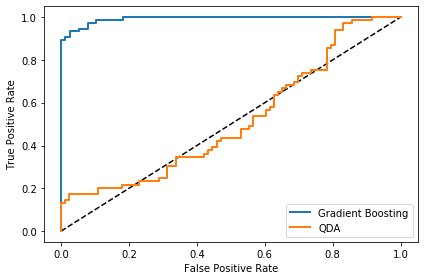

In [79]:
plt.plot(fpr, tpr, linewidth=2, label = 'Gradient Boosting')
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr2, tpr2, linewidth=2, label = 'QDA')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig('../../plots/roccurve.png', dpi = 200);

In [60]:
roc_auc_score(cross_val_predict(lda_mod, train_df_minmax, train_labels), train_labels)

/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.9541991341991343